## MNIST 데이터 셋을 train set와 test set(5만 개, 2만 개)으로 나누어 가능한 높은 정확도 달성해 보기.(몇 가지 방법으로 시도하는 과정도 보여주면 좋음)

In [31]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
# 난수 초기화
np.random.seed(42)

In [32]:
from sklearn import datasets

mnist = datasets.load_digits()

X, y = mnist['data'], mnist['target']
X_train, X_test, y_train, y_test = X[:1300], X[1300:], y[:1300], y[1300:]

In [16]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV

extra_trees_clf = ExtraTreesClassifier(random_state=42)

param_grid = [{'n_estimators' : [350, 400, 450],
               'max_depth' : [8, 10, 12]}]
#1차 : [10,20,30,40,50]  =>  {'n_estimators': 50}
#       [8, 10, 12]  => 12
#2차 : [50, 100, 200, 300]  =>  {'n_estimators': 350}
#3차 : [350, 400, 450]
grid_search2 = GridSearchCV(extra_trees_clf, param_grid, cv =5,
                          scoring='neg_mean_squared_error',
                          return_train_score=True)
grid_search2.fit(X_train, y_train)
grid_search2.best_params_

{'max_depth': 12, 'n_estimators': 350}

In [34]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()

param_grid = [{'n_neighbors' : [3, 4, 5]}]

grid_search3 = GridSearchCV(knn_clf, param_grid, cv =5, verbose = 3, n_jobs =-1)
grid_search3.fit(X_train, y_train)
grid_search3.best_params_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.5s finished


{'n_neighbors': 3}

In [35]:
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

rnd_clf = RandomForestClassifier(n_estimators =350, max_depth = 12, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators =350, max_depth = 12, random_state=42)
knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=3)
svc_clf =  Pipeline([("scaler", StandardScaler()), 
                    ("svc_clf", SVC(kernel="poly", degree=3, gamma='auto', C=1))
                   ])

voting_clf = VotingClassifier(
    estimators=[('etc', extra_trees_clf), ('rf', rnd_clf),  
                ('svc', svc_clf), ('knn', knn_clf)],voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('etc',
                              ExtraTreesClassifier(bootstrap=False,
                                                   ccp_alpha=0.0,
                                                   class_weight=None,
                                                   criterion='gini',
                                                   max_depth=12,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                  

In [37]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier()

param_grid = [{'max_leaf_nodes' : [20, 30, 40]}]
grid_search4 = GridSearchCV(dt_clf, param_grid, scoring='accuracy', cv = 5,  n_jobs = -1)
grid_search4.fit(X_train, y_train)
grid_search4.best_params_

{'max_leaf_nodes': 40}

In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_leaf_nodes = 40), n_estimators=200,
    algorithm="SAMME.R", learning_rate=1, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features=None,
                                                         max_leaf_nodes=40,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                         

In [39]:
from sklearn.metrics import accuracy_score

for clf in (extra_trees_clf, rnd_clf, svc_clf, knn_clf, voting_clf, ada_clf):
    clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)
    print(clf.__class__.__name__,accuracy_score(y_test, y_pred))

ExtraTreesClassifier 0.9476861167002012
RandomForestClassifier 0.9295774647887324
Pipeline 0.903420523138833
KNeighborsClassifier 0.96579476861167
VotingClassifier 0.9496981891348089
AdaBoostClassifier 0.9295774647887324


In [41]:
#가장 높은 KNeighborsClassifier의 confusion matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_train_pred_knn = cross_val_predict(knn_clf, X_train, y_train, cv=5)

print(confusion_matrix(y_train, y_train_pred_knn))

[[129   0   0   0   0   0   0   0   0   0]
 [  0 126   1   0   0   0   1   0   2   2]
 [  0   4 122   1   0   0   0   0   2   0]
 [  0   0   0 129   0   0   0   0   3   0]
 [  0   1   0   0 127   0   0   1   0   1]
 [  0   0   0   0   1 125   0   0   0   5]
 [  1   0   0   0   0   0 129   0   0   0]
 [  0   0   0   0   0   0   0 127   0   2]
 [  0  14   2   2   0   0   0   0 110   0]
 [  0   3   0   5   0   1   0   4   2 115]]


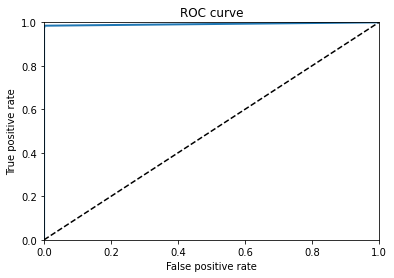

In [13]:
#가장 높은 KNeighborsClassifier의 roc 곡선
from sklearn.metrics import roc_curve
y_train_5 = (y_train == 5)
y_probas_kneighbor = cross_val_predict(knn_clf, X_train, y_train_5, cv=3,
                             method="predict_proba")
y_scores_kneighbor = y_probas_kneighbor[:, 1]
fpr, tpr, threshold = roc_curve(y_train_5, y_scores_kneighbor)

def plot_roc_curve(fpr, tpr, label=None):
    plt.title('ROC curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],"k--")
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')

plot_roc_curve(fpr, tpr)
plt.show()

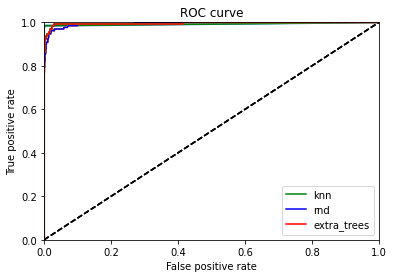

In [44]:
#기타 분류기와의 비교
#RandomForestClassifier
y_probas_forest = cross_val_predict(rnd_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")
y_scores_forest = y_probas_forest[:, 1] 
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

#ExtraTreesClassifier
y_probas_extra = cross_val_predict(extra_trees_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")
y_scores_extra = y_probas_extra[:, 1] 
fpr_extra, tpr_extra, thresholds_extra = roc_curve(y_train_5,y_scores_extra)


plot_roc_curve(fpr, tpr)
plt.plot(fpr, tpr,"g", label="knn")
plot_roc_curve(fpr_forest, tpr_forest)
plt.plot(fpr_forest, tpr_forest,"b", label="rnd")
plot_roc_curve(fpr_extra, tpr_extra)
plt.plot(fpr_extra, tpr_extra,"r", label="extra_trees")

plt.legend(loc="lower right")
plt.show()